# Model-Free Method: Q-learning and TD(0)
In these models the transition probability matrices p(s'| s, a) and r(s, a, s') are not known

In [1]:
#importing dependencies
from gym import Env
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


# Building a dangerous gridworld

In [2]:
#this class defines a 2D coordinate system
class Coordinate(object):
  def __init__(self, x, y, is_dangerous):
    #changing x will move vertically and y will move horizontally
    self.x = x
    self.y = y
    self.danger = is_dangerous
  def __str__(self):
    return "({}, {}, {})".format(self.x, self.y, self.danger)

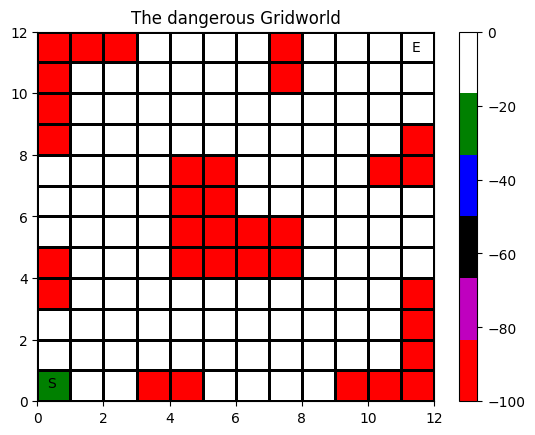

In [3]:
#We need extend the functionalities of the Env class (the superclass here is the env class)
#This is the environment class: where our agent will learn.
class dangerous_gridWorld(Env):
  #override the the following, in the Env class
  def __init__(self, grid_specs=[12,12], start_state=[0, 0], end_state=[11, 11], danger_states = [[False, False, False, True, True, False, False, False, False, True, True, True], 
                                                                                                  [False, False, False, False, False, False, False, False, False, False, False, True],
                                                                                                  [False, False, False, False, False, False, False, False, False, False, False, True],
                                                                                                  [True, False, False, False, False, False, False, False, False, False, False, True], 
                                                                                                  [True, False, False, False, True, True, True, True, False, False, False, False], 
                                                                                                  [False, False, False, False, True, True, True, True, False, False, False, False], 
                                                                                                  [False, False, False, False, True, True, False, False, False, False, False, False], 
                                                                                                  [False, False, False, False, True, True,  False, False, False, False, True, True], 
                                                                                                  [True, False, False, False, False, False, False, False, False, False, False, True],
                                                                                                  [True, False, False, False, False, False, False, False, False, False, False, False],
                                                                                                  [True, False, False, False, False, False, False, True, False, False, False, False], 
                                                                                                  [True, True, True, False, False, False, False, True, False, False, False, False]]):
  
    #initialize out setting, state space, action and rewards
    self.grid_specs = grid_specs
    #Dynamics of the MDP
    #action space
    self.actions =  ['left', 'up', 'right', 'down']
    #state space (defines the shape of the gridworld)
    #the states in itself has the knowledge of whether it is dangerous
    self.states = [[Coordinate(i, j, danger_states[i][j]) for j in range(grid_specs[1])] for i in range(grid_specs[0])]
    #for a SSPP
    self.start_state = Coordinate(start_state[0], start_state[1], False)
    self.end_state = Coordinate(end_state[0], end_state[1], False)
    
    #since the transition probabilities are deterministic 
    #(i.e.: next state and reward is determinitic and hence we don't need to define it)

  def get_D_i(self):
    D_i = np.zeros(shape=self.grid_specs, dtype=bool)
    for i in range(self.grid_specs[0]):
      for j in range(self.grid_specs[1]):
        if (self.states[i][j].danger==True):
          D_i[i][j] = True
        elif i==0 or j==0:
          if i==0 and (j<self.grid_specs[1]-1 and self.states[i][j+1].danger == True) or (j-1>0 and self.states[i][j-1].danger == True):
            D_i[i][j] = True
          elif j==0 and (i<self.grid_specs[0]-1 and self.states[i+1][j].danger == True) or (i-1>0 and self.states[i-1][j].danger == True):
            D_i[i][j] = True  
          else:
            D_i[i][j] = False
        elif i==self.grid_specs[0]-1 or j==self.grid_specs[1]-1:
          if i==self.grid_specs[0]-1 and (j<self.grid_specs[1]-1 and self.states[i][j+1].danger == True) or (j-1>0 and self.states[i][j-1].danger == True):
            D_i[i][j] = True
          elif j==self.grid_specs[1]-1 and (i<self.grid_specs[0]-1 and self.states[i+1][j].danger == True) or (i-1>0 and self.states[i-1][j].danger == True):
            D_i[i][j] = True  
          else:
            D_i[i][j] = False
        elif (self.states[i+1][j].danger == True or self.states[i-1][j].danger == True) or (self.states[i][j+1].danger == True or self.states[i][j-1].danger ==True):
          D_i[i][j] = True
    return D_i

  def step(self, state, action):
    #current state is of Coordinate type and action is a single string

    #define the dynamics of a single step
    #(0,0) is the start state and (7, 7) is the terminal state
    #Going outside the grid incurs a penalty of -5 and entering the dangerous states makes the penalty be as high as -20 (hoping teacher can save the day)
    #x axis and y axis are inverted here
    next_state = None
    #flag_out = False
    reward = -1
    if action == 'left':
      if state.y - 1 < 0:
        #going out of the grid
        next_state = self.states[state.x][state.y]
        #flag_out = True
      else:
        next_state = self.states[state.x][state.y-1]
        
    elif action == "up":
      if state.x + 1 > self.end_state.x:
        #going out of the grid
        next_state = self.states[state.x][state.y]
        #went out of the grid
      else:
        next_state = self.states[state.x+1][state.y]
          
    elif action == "right":
      if state.y + 1 > self.end_state.y:
        #going out of the grid
        next_state = self.states[state.x][state.y]
        #went out of the grid
      else:
        next_state = self.states[state.x][state.y+1]
        #if the next state is a danger state: then a reward of -20 will be encountered

    elif action == "down":
      if state.x - 1 < 0:
        #going out of the grid
        next_state = self.states[state.x][state.y]
        #flag_out = True
      else:
        next_state = self.states[state.x-1][state.y]
        #if the next state is a danger state: then a reward of -20 will be encountered
    else:
      print("Invalid Action")
      next_state = state
      reward = 0

    #if flag_out== True:
    #  reward = -20
    #if the next state is a danger state: then a reward of -20 will be encountered
    if self.states[next_state.x][next_state.y].danger == True:
      reward = -100

    done = False
    if next_state.x == self.end_state.x and next_state.y == self.end_state.y:
      done = True
    #an empty dictionary needs to be returned as prescribed by the documents. This is used for returning any extra information
    info = {}
    return next_state, reward, done, info

  def render(self, current_state, title=""):
    #render graphics for the environment
    mesh_gd = np.zeros((self.end_state.x+1, self.end_state.y+1))
    for i in range(mesh_gd.shape[0]):
      for j in range(mesh_gd.shape[1]):
        if self.states[i][j].danger == True:
          mesh_gd[i][j] = -100
        else:
          mesh_gd[i][j] = 0 
    mesh_gd[current_state.x][current_state.y] = -20
    plt.pcolormesh(mesh_gd, edgecolors='black', linewidth=2, cmap = col.ListedColormap(['r', 'm', 'k', 'b', 'g', 'w']))
    plt.colorbar()
    #adjusting text according to the relative positioning
    plt.figtext(0.71, 0.84, "E")
    plt.figtext(0.14, 0.14, "S")
    plt.title("The dangerous Gridworld"+title)
   
  def disp2(self, dang_states):
    mesh_gd = np.zeros((self.end_state.x+1, self.end_state.y+1))
    for i in range(mesh_gd.shape[0]):
      for j in range(mesh_gd.shape[1]):
        if self.states[i][j].danger == True:
          mesh_gd[i][j] = -100
        elif dang_states[i][j] == True:
          mesh_gd[i][j] = -40
        else:
          mesh_gd[i][j] = 0
    
    plt.pcolormesh(mesh_gd, edgecolors='black', linewidth=2, cmap = col.ListedColormap(['r', 'y', 'w']))
    plt.colorbar()
    #adjusting text according to the relative positioning
    plt.figtext(0.71, 0.84, "E")
    plt.figtext(0.14, 0.14, "S")
    plt.title("The teacher's knowledge of the grid world")

  def reset(self):
    #reset at the end of an episode
    return self.start_state
  
  def is_terminal(self, state):
    if state.x == self.end_state.x and state.y == self.end_state.y:
      return True
    return False

  def __str__(self):
    print("states: ")
    for i in range(self.grid_specs[0]):
      for j in range(self.grid_specs[1]):
        print(self.states[i][j])
    print('Start State: {}'.format(self.start_state))
    print('End State: {}'.format(self.end_state))
    return "actions: {}".format(self.actions)

gw = dangerous_gridWorld()
#gw.render(Coordinate(0, 0, True))
gw.render(gw.start_state)
#gw.render(gw.end_state)
#n_state, reward = gw.step(gw.states[1][2], "down")
#print(n_state, reward)

# Policy Iteration 

Evaluation:
Start with $\pi_{n}, V_0 = 0$
$$\large v_{k+1}(s) = \sum_a \pi_{n}(a | s) \sum_{s', r} p(s', r | s, a)[r + \gamma v_k(s')]$$
Obtain $V_{\pi_n}$ the updates converge

Improvement:

$$\large \pi_{n+1}(s) = \text{argmax}_a \sum_{s', r} p(s', r | s, a)[r + \gamma v_{\pi_{n}}(s')]$$

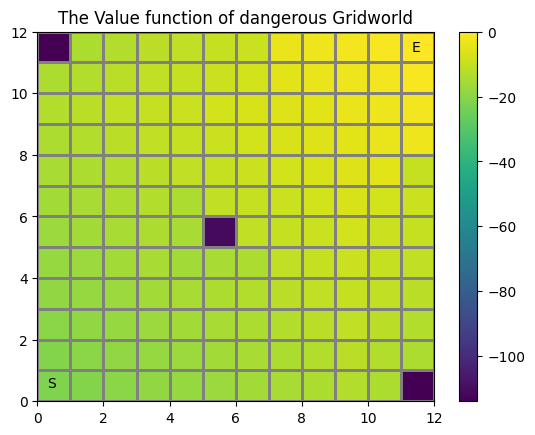

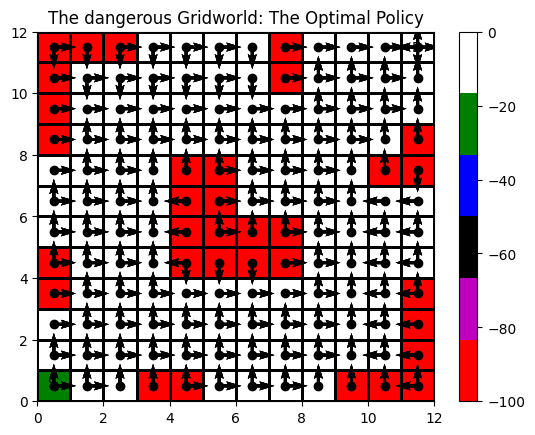

In [4]:
#Step 1: policy iteration (for getting the optimal policy) to get the optimal policy
#Step 2: (a) Q-learning (Sample based technique to get optimal value function and policy)
#        (b) SARSA/ and Expected Sarsa to compare performance
#Step 3: To find compare the performance of the teacher-student based algorithm with the above
class policy_itertion_Agent(object):
  #NOTE: env is the environment object
  def __init__(self, env):
    #for tabular methods V and pi is sufficient (Here we are trying to maximize reward)
    self.V = np.zeros((env.grid_specs[0], env.grid_specs[1]))
    #generates the policy map
    #pi has 1 if you can select an action otherwise it will be 0
    self.pi_indicator = np.ones((env.grid_specs[0], env.grid_specs[1], len(env.actions))) #3D matrix
    #This will store the conditional probability p(s', r|s, a)
    #for this the P values will be equiprobable in all the next states that is optimal
    self.pi_prob = self.update_P()
    #discount factor
    self.gamma = 1
  def reset(self, env):
    self.V = np.zeros((env.grid_specs[0], env.grid_specs[1]))
    #generates the policy map
    #pi has 1 if you can select an action otherwise it will be 0
    self.pi_indicator = np.ones((env.grid_specs[0], env.grid_specs[1], len(env.actions))) #3D matrix
    #This will store the conditional probability p(s', r|s, a)
    #for this the P values will be equiprobable in all the next states that is optimal
    self.pi_prob = self.update_P()

  def reset_V(self, env):
    self.V = np.zeros((env.grid_specs[0], env.grid_specs[1]))
  def update_P(self):
    return self.pi_indicator / (np.sum(self.pi_indicator, axis=2, keepdims=True))

  def update_state(self, env, this_state):
    # The value of the terminal state is always set to 0
    if env.is_terminal(this_state) == True:
      return 0
    #non terminal states
    update_value = 0
    for action in env.actions:  #SUM OVER ALL THE ACTIONS a
      #actions possible are same for everyone here
      next_state, reward, _, _ = env.step(this_state, action)
      #Bellman update rule, deterministic environment and hence there is no inner loop -- pi (a|s)
      update_value = update_value + self.pi_prob[this_state.x, this_state.y, env.actions.index(action)]*(reward + self.gamma*self.V[next_state.x, next_state.y])
    return update_value

  def policy_evaluation(self, env, max_iter = 1000, epsilon = 1e-9):
    #finds the value function of the current policy
    for itr in range(max_iter):
      theta = 0    
      #This is iteration over all the states
      for i in range(self.V.shape[0]):
        for j in range(self.V.shape[1]):
          if env.is_terminal(env.states[i][j]):
            break
          old_val = np.copy(self.V[i, j])
          self.V[i, j] = self.update_state(env, env.states[i][j])   #every time updating v_k --> v_k+1 until convergence
          theta = np.maximum(theta, np.abs(self.V[i, j] - old_val))
      if theta < epsilon:
        break
  #return all the best actions
  def greedy_action(self, env, this_state):
    import math
    # The value of the terminal state is always set to 0
    if env.is_terminal(this_state) == True:
      pol_new = [0, 1, 2, 3] #returns the actions possible 
      return pol_new
    #non terminal states
    max_value = -1*float('inf')
    temp_actions = []
    ctr = 0
    for action in env.actions:
      #actions possible are same for everyone here
      next_state, reward, _, _ = env.step(this_state, action)
      #Bellman update rule, deterministic environment and hence there is no inner loop
      next_value = (reward + self.gamma*self.V[next_state.x, next_state.y])
      #index of maximizing action  -- select all the actions that maximize the reward
      if math.isclose(next_value, max_value):  #[1] was selected, if action 2 also gives the same reward add that to list as well 
        temp_actions.append(ctr)
      elif next_value > max_value:
        temp_actions =  []
        temp_actions.append(ctr)
        max_value = next_value
      
      ctr = ctr + 1
      
    return temp_actions
  
  def policy_improvement(self, env):
    for i in range(self.V.shape[0]):
      for j in range(self.V.shape[1]):
        #if env.is_terminal(env.states[i][j]):
        #    break
        #Need to get the optimal action
        best_actions = self.greedy_action(env, env.states[i][j])
        #resets the pi to change the values
        for ac in range(len(env.actions)):
          self.pi_indicator[i, j, ac] = 0
        for k in best_actions:
          #all greedy actions next
          self.pi_indicator[i, j, k] = 1 

    self.pi_prob = self.update_P()

  #this is the policy iteration algorithm
  def policy_itertion(self, env):
    while True:
      old_V = np.copy(self.V)
      self.reset_V(env)
      self.policy_evaluation(env)   # is done with the current policy -- fixed 
      #this improvement, once this ends improving, we are sure that the algorithm has converged
      self.policy_improvement(env)   # this is done with fixed value function
      #once improvement is no longer possible
      if np.allclose(old_V, self.V):
        break

  def print_optimal_value_function(self, env):
    #env.render(env.start_state)
    plt.pcolormesh(self.V, edgecolors='grey')
    plt.figtext(0.71, 0.84, "E")
    plt.figtext(0.14, 0.14, "S")
    plt.title("The Value function of dangerous Gridworld")
    plt.colorbar()
    plt.show()
    #print(self.V)
    
  def print_optimal_policy(self, env):
    env.render(env.states[0][0], ": The Optimal Policy")
    for i in range(env.grid_specs[0]):
       for j in range(env.grid_specs[1]):
        plt.scatter(i+0.5, j+0.5, color='black')
        for k in range(len(env.actions)): 
          #print arrow (x, y, dx, dy) 
          #print along j first (because here we are printing from row-wise from bottom to up but pi_indicator, 
          #and quiver follow caresian convention, which is opposite of pcolormesh convention)
          if self.pi_indicator[i, j, 0]==1:
            #left
            plt.quiver(j+0.5, i+0.5, -0.4, 0, color='black')
          if self.pi_indicator[i, j, 1]==1:
            #up
            plt.quiver(j+0.5, i+0.5, 0, 0.4, color='black')
          if self.pi_indicator[i, j, 2]==1:
            #right
            plt.quiver(j+0.5, i+0.5, 0.4, 0, color='black')
          if self.pi_indicator[i, j, 3]==1:
            #down
            plt.quiver(j+0.5, i+0.5, 0, -0.4, color='black')
          

#testing performance of policy iteration

agent_p_iter = policy_itertion_Agent(gw)  
#agent_p_iter.reset(gw) 
agent_p_iter.policy_itertion(gw)
agent_p_iter.print_optimal_value_function(gw)
agent_p_iter.print_optimal_policy(gw)

# $\textcolor{red}{\text{Assignment 2-3 (25 points)}} $

# Q1: TD($\lambda$) version (10 points)

We consider episodic tasks here.

$$\large V_\pi(s) = \sum_{a \in \mathcal{A}(s)} \pi(a|s) \sum_{s', r} p(s' | s, a)[r(s, a, s') + V_\pi(s')]$$

Implemented by exploring the world using the policy. 

for entire episode, the TD($\lambda$) update for the policy $\pi$ will be -- 

$$\large V_{k+1}(s_k) = V_{k}(s_k) + \gamma \sum_{m=k}^L \alpha_k \lambda^{m-k} [r(s_m, a_m, s_{m+1}) +  V_k(s_{m+1}) - V_k(s_{m})]$$

where, $\lambda \in [0, 1]$, represents the weightage to temporal differences in the future; and $L$ is the end of the trajectory length.

as $n \rightarrow \infty, V_k \rightarrow V_\pi$

**We will follow a every visit strategy.**

In [52]:
#testing the environment with sample based methods: Used (Q-learning): OFF Policy learning rule
class TDlam_Agent(object):
  def __init__(self, env, pi=None, eps=0.1, lambd=0.2):
    #for tabular methods V and pi is sufficient (Here we are trying to maximize reward)
    #Q-function
    self.V = np.zeros((env.grid_specs[0], env.grid_specs[1])).astype('float64')
    self.pi = pi
    #pi is the policy distribution you want to evaluate, else we work with uniform distributions
    if self.pi is None:
        #initially select a random policy
        self.pi_indicator = np.ones((env.grid_specs[0], env.grid_specs[1], len(env.actions)))  # ((x, y), a) -- dimensions
    else:
        self.pi_indicator = self.pi
    #discount factor
    self.eps = 0.1  #epsilon greedy parameter
    self.gamma = 0.90  #discount factor
    #present dynamics
    self.prev_state = None
    self.prev_action = None
    #this is for scheduling the learning rate
    self.num_visit = np.zeros((env.grid_specs[0], env.grid_specs[1]))

    # additions for TD(l)
    self.lambd = lambd
    self.state_history = []
    self.temp_diff_history = []
    
  def reset(self, env, pi=None):
    #for tabular methods V and pi is sufficient (Here we are trying to maximize reward)
    #V-function
    self.V = np.zeros((env.grid_specs[0], env.grid_specs[1])).astype('float64')
    if self.pi is None:
        #initially select a random policy
        self.pi_indicator = np.ones((env.grid_specs[0], env.grid_specs[1], len(env.actions)))  # ((x, y), a) -- dimensions
    else:
        self.pi_indicator = self.pi
    #target policy: argmax (always choosing the best action)
    self.prev_state = None
    self.prev_action = None
    #this is for scheduling the learning rate according to the state
    self.num_visit = np.zeros((env.grid_specs[0], env.grid_specs[1]))
    
    # additions for TD(l)
    self.state_history = []
    self.temp_diff_history = []

  #this is for exploration/exploration tradeoff
  def select_action(self, env):
    # epsilon greedy action selection -- that is if less than eps select any action 
    #else select randomly from equiprobable action
    if np.random.rand() < self.eps:
        return np.random.choice(len(env.actions))
    else:
        actions_valid = np.where(self.pi_indicator[self.prev_state.x, self.prev_state.y, :] == 1)[0]
        # choose from equally valid actions
        return np.random.choice(actions_valid) 
  
  def lr_scheduler(self, this_state):
    #a = b = 1 (lr = a/(m+b) : for the mth update)
    #return 0.1
    return 1/(1+self.num_visit[this_state.x, this_state.y])
      
  def start(self, env):
    #this is a beginning of an episode
    self.prev_state = env.start_state
    #here action is chosen in accordance to the behaviour policy of the agent
    #we are choosing this action as a number, convert to actual action using env.actions
    #take action in an offpolicy way (here we are using epsilon greedy)
    self.prev_action = self.select_action(env)
    
  def step(self, env, cumu_reward):
    #first 2 components represent the state and the second one represent the reward
    this_state, reward, _, _ = env.step(self.prev_state, env.actions[self.prev_action])
    cumu_reward += reward

    if env.is_terminal(this_state) == True:
      return self.end(env, reward), cumu_reward
      
    #TD(0)-learning update rule  -- r(s, a, s') + V(s') - V(s) --- s' is the this_state
    del_t = reward + self.gamma*self.V[this_state.x, this_state.y] - self.V[self.prev_state.x, self.prev_state.y]

    # will be done at the end of the trajectory -- deletion for TD(l)
    # self.V[self.prev_state.x, self.prev_state.y] = self.V[self.prev_state.x, self.prev_state.y] + self.lr_scheduler(self.prev_state)*del_t

    # additions for TD(l)
    self.state_history.append(self.prev_state)
    self.temp_diff_history.append(del_t)
    
    #Now we are in the next_state
    self.prev_state = this_state
    self.prev_action = self.select_action(env)
    # prevent overflow
    # if len(self.temp_diff_history) > 10:
    #     return True, cumu_reward    
    # else:
    return False, cumu_reward

  # addition for the TD(l) algorithm -- updating all the states based on the current trajectory
  def update_states_trajEnd(self):
    TL = len(self.temp_diff_history)
    
    self.V[self.state_history[TL-1].x, self.state_history[TL-1].y] += self.lr_scheduler(self.state_history[TL-1])*self.gamma*self.temp_diff_history[TL-1] 
    
    for i in range(TL-2, -1, -1):  # go backwards
      # perform the DP to collect the cumulative temporal difference
      self.temp_diff_history[i] = self.lambd*self.temp_diff_history[i+1] + self.temp_diff_history[i]
      self.V[self.state_history[i].x, self.state_history[i].y] += self.lr_scheduler(self.state_history[i])*self.gamma*self.temp_diff_history[i]
    
    del self.state_history, self.temp_diff_history    
    self.state_history = []
    self.temp_diff_history = []
  
  def end(self, env, reward):
    #whenever this_state will be the end_state this will be called, for the end state you don't see the next state
    del_t = reward - self.V[self.prev_state.x, self.prev_state.y]

    # deletion for TD(l)
    # self.V[self.prev_state.x, self.prev_state.y] = self.V[self.prev_state.x, self.prev_state.y] + self.lr_scheduler(self.prev_state)*del_t
    #returns true when the current path ends
    # additions for history in TD(l)
    self.state_history.append(self.prev_state)
    self.temp_diff_history.append(del_t)
    
    return True

  def complete_trajectory(self, env):
    completed = False
    reward_rec = 0
    #this completes a trajectory
    while True:
      prev_state= self.prev_state
      prev_action = self.prev_action
      # the step function takes one step -- and returns if the agent has entered the terminal state or not
      completed, reward_rec = self.step(env, reward_rec)
      if completed == True:
        self.update_states_trajEnd()  # additions for TD(l) for computing DP at the end of the trajectory
        break
      #updating the number of visits
      self.num_visit[prev_state.x, prev_state.y] += 1  
    return reward_rec

  def TD_learning(self, env, max_runs=5000, avg_over=5, to_plot=True):
    history = np.zeros((avg_over, max_runs))
    for a in range(avg_over):
      self.reset(env)       
      for i in range(max_runs):
        self.start(env)
        history[a, i] = self.complete_trajectory(env)
        if i%2000 == 0:
          print("Completed run {}".format(i))
    
    avg_history = np.mean(history, axis=0)
    if to_plot == True:
      plt.plot(avg_history)
      plt.xlabel("Trajectory number")
      plt.ylabel("Reward")
      plt.title("How the agent maximizes reward over runs in sample based method")
      plt.show()
    
    return avg_history

  def display_num_visits(self):
    #env.render(env.start_state)
    plt.pcolormesh(np.sum(self.num_visit, axis=2), edgecolors='grey')
    plt.figtext(0.71, 0.84, "E")
    plt.figtext(0.14, 0.14, "S")
    plt.title("number of visits in each state")
    plt.colorbar()
    plt.show()
    #print(self.V)
  
  def print_value_function(self, env):
    #env.render(env.start_state)
    plt.pcolormesh(self.V, edgecolors='grey')
    plt.figtext(0.71, 0.84, "E")
    plt.figtext(0.14, 0.14, "S")
    plt.title("The Value function of dangerous Gridworld")
    plt.colorbar()
    plt.show()
    #print(self.V)

  def print_policy(self, env):
    env.render(env.states[0][0], ": The Optimal Policy by Q-learning")
    for i in range(env.grid_specs[0]):
       for j in range(env.grid_specs[1]):
        plt.scatter(i+0.5, j+0.5, color='black')
        for k in range(len(env.actions)): 
          #print arrow (x, y, dx, dy) 
          #print along j first (because here we are printing from row-wise from bottom to up but pi_indicator, 
          #and quiver follow caresian convention, which is opposite of pcolormesh convention)
          if self.pi_indicator[i, j, 0]==1:
            #left
            plt.quiver(j+0.5, i+0.5, -0.5, 0, color='black')
          if self.pi_indicator[i, j, 1]==1:
            #up
            plt.quiver(j+0.5, i+0.5, 0, 0.5, color='black')
          if self.pi_indicator[i, j, 2]==1:
            #right
            plt.quiver(j+0.5, i+0.5, 0.5, 0, color='black')
          if self.pi_indicator[i, j, 3]==1:
            #down
            plt.quiver(j+0.5, i+0.5, 0, -0.5, color='black')

**Uniform Policy**

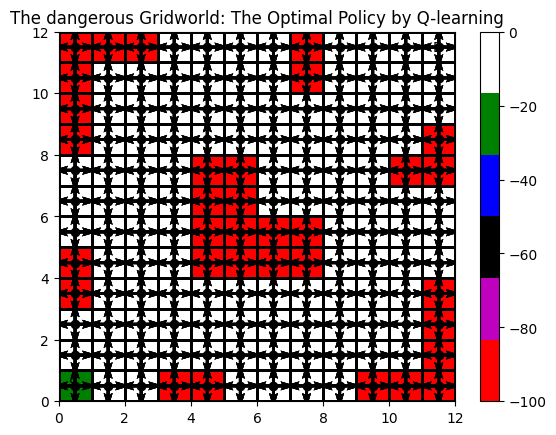

In [40]:
td_agent = TDlam_Agent(gw)
td_agent.print_policy(gw)

Completed run 0
Completed run 2000
Completed run 4000
Completed run 6000
Completed run 8000


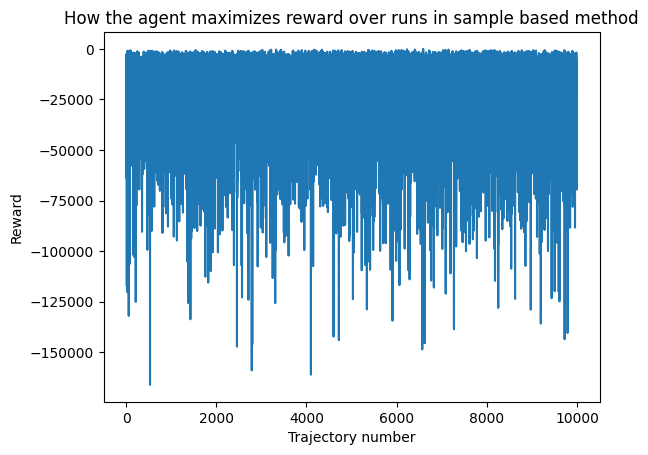

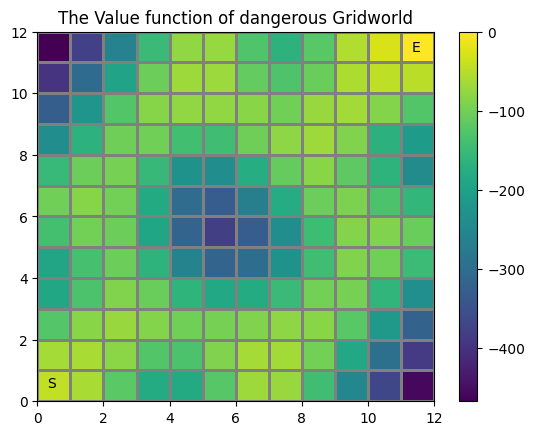

In [41]:
td_agent.TD_learning(gw, 10000, 1)
td_agent.print_value_function(gw)

**Optimal Policy**

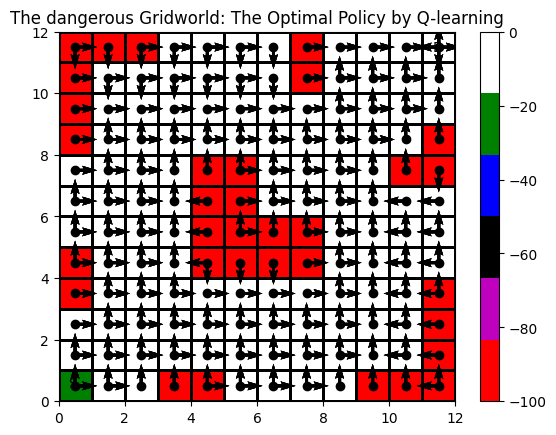

In [47]:
td_agent = TDlam_Agent(gw, agent_p_iter.pi_indicator)
td_agent.print_policy(gw)

Completed run 0
Completed run 2000
Completed run 4000
Completed run 6000
Completed run 8000


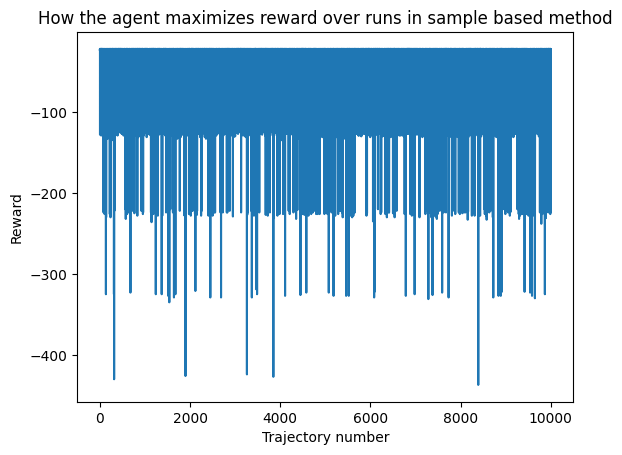

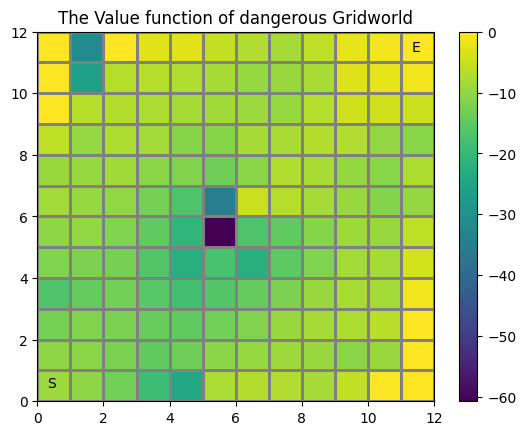

In [48]:
td_agent.TD_learning(gw, 10000, 1)
td_agent.print_value_function(gw)

**Compare convergence of different lambdas for optimal policy**

In [84]:
def compare_losses(lambdas = [0.0, 0.25, 0.5, 0.75, 1.0]):
    losses = []
    for l in lambdas:
        td_agent = TDlam_Agent(gw, agent_p_iter.pi_indicator, lambd=l)
        losses.append(td_agent.TD_learning(gw, 5000, 1, to_plot=False))
    
    return losses
losses = compare_losses()

Completed run 0
Completed run 2000
Completed run 4000
Completed run 0
Completed run 2000
Completed run 4000
Completed run 0
Completed run 2000
Completed run 4000
Completed run 0
Completed run 2000
Completed run 4000
Completed run 0
Completed run 2000
Completed run 4000


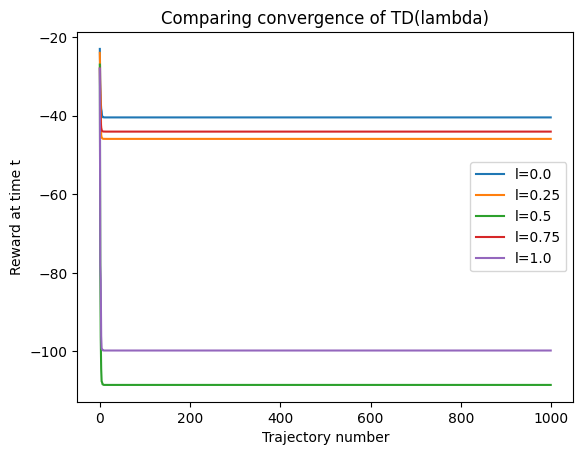

In [85]:
def plot_comparison(losses, alpha=0.4, lambdas = [0.0, 0.25, 0.5, 0.75, 1.0]):
    weights = alpha ** np.arange(len(losses[0]))
    # print(weights)
    # print(losses[1])
    for i in range(len(losses)):
        losses[i] = np.cumsum(losses[i]*weights)
        plt.plot(losses[i][0:1000], label="l="+str(lambdas[i]))
    plt.xlabel("Trajectory number")
    plt.ylabel("Reward at time t")
    plt.title("Comparing convergence of TD(lambda)")
    plt.legend()
    plt.show()
plot_comparison(losses)

In this case l=0.5 converges fastest

**For Random Policies**

Completed run 0
Completed run 0
Completed run 0
Completed run 0
Completed run 0


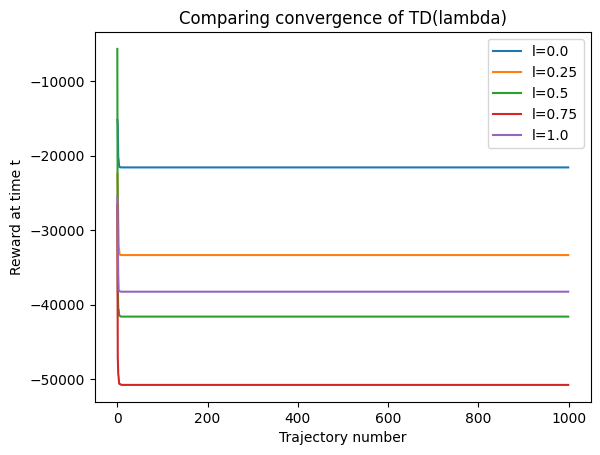

In [78]:
def compare_losses(lambdas = [0.0, 0.25, 0.5, 0.75, 1.0]):
    losses = []
    for l in lambdas:
        td_agent = TDlam_Agent(gw, lambd=l)
        losses.append(td_agent.TD_learning(gw, 2000, 1, to_plot=False))
    
    return losses
losses = compare_losses()

def plot_comparison(losses, alpha=0.4, lambdas = [0.0, 0.25, 0.5, 0.75, 1.0]):
    weights = alpha ** np.arange(len(losses[0]))
    # print(weights)
    # print(losses[1])
    for i in range(len(losses)):
        losses[i] = np.cumsum(losses[i]*weights)
        plt.plot(losses[i][0:1000], label="l="+str(lambdas[i]))
    plt.xlabel("Trajectory number")
    plt.ylabel("Reward at time t")
    plt.title("Comparing convergence of TD(lambda)")
    plt.legend()
    plt.show()
plot_comparison(losses)

In this case l=0.75 converges fastest

# Q2: Model-Based Q-learning (8 points)

Tabular Q-learning

$$\large Q_\pi(s, a) = \sum_{s', r} p(s'| s, a)[r(s, a, s') + \max_{a'\in\mathcal{A}(s')} \gamma Q_\pi(s', a')]$$


0 steps completed.
2000 steps completed.
4000 steps completed.


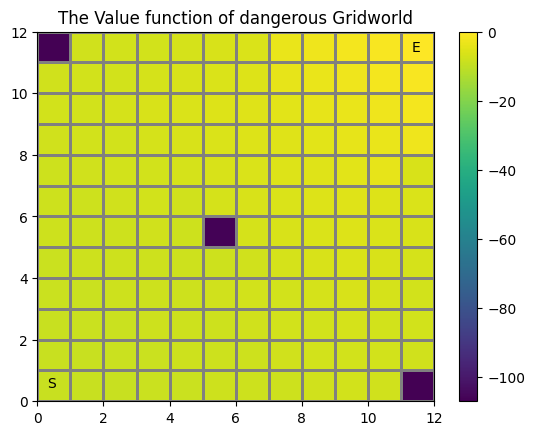

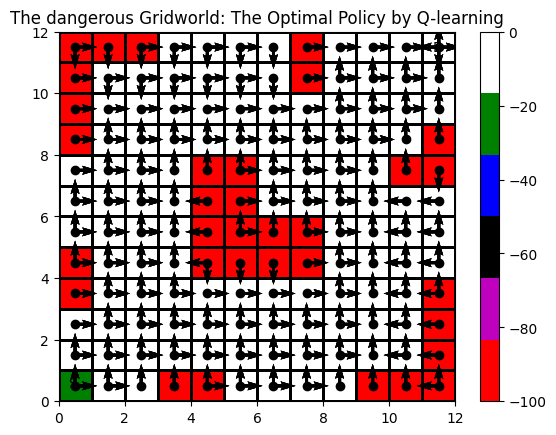

In [9]:
#testing the environment with sample based methods: Used (Q-learning): OFF Policy learning rule
class Q_learning_AgentTabular(object):
  def __init__(self, env):
    #eps -- for epsilon greedy sampling
    #for tabular methods V and pi is sufficient (Here we are trying to maximize reward)
    #Q-function
    self.Q = np.zeros((env.grid_specs[0], env.grid_specs[1], len(env.actions)))
    self.Q_new = np.zeros((env.grid_specs[0], env.grid_specs[1], len(env.actions)))
    self.V = np.zeros((env.grid_specs[0], env.grid_specs[1]))
    self.pi_indicator = np.zeros((env.grid_specs[0], env.grid_specs[1], len(env.actions)))
    #discount factor
    self.gamma = 0.9
    
  def argmax(self, vec):
    import math
    max_value = np.max(vec)
    ctr = 0
    all_maxpos = []
    for val in vec:
      if math.isclose(val, max_value):
        all_maxpos.append(ctr)
      ctr += 1
    return all_maxpos
 
  def q_learning(self, env, max_runs=5000):
    for i in range(max_runs):
      self.Q = np.copy(self.Q_new)
      for x in range(len(env.states)):
        for y in range(len(env.states[0])):
          for a in range(len(env.actions)):
            # since after selecting the action here, the next state is deterministic, hence we can simply p(next|curr, act) = 1, 0 otherwise
            if env.is_terminal(env.states[x][y]) == True:
              self.Q_new[x, y, a] = 0
            else:
              next_state, reward, _, _ = env.step(env.states[x][y], env.actions[a])
              self.Q_new[x, y, a] = reward + self.gamma*np.max(self.Q[next_state.x, next_state.y, :])
      
      if i%2000 == 0:
        print(str(i)+" steps completed.")
            
  def compute_V_and_pi(self):
    #computes V* and pi*
    self.V = np.max(self.Q, axis=2)
    for i in range(self.V.shape[0]):
      for j in range(self.V.shape[1]):
        opt_act = self.argmax(self.Q[i, j, :])
        for ac in opt_act:
          self.pi_indicator[i, j, ac] = 1
            
  def print_optimal_value_function(self, env):
    #env.render(env.start_state)
    plt.pcolormesh(self.V, edgecolors='grey')
    plt.figtext(0.71, 0.84, "E")
    plt.figtext(0.14, 0.14, "S")
    plt.title("The Value function of dangerous Gridworld")
    plt.colorbar()
    plt.show()
    #print(self.V)

  def print_optimal_policy(self, env):
    env.render(env.states[0][0], ": The Optimal Policy by Q-learning")
    for i in range(env.grid_specs[0]):
       for j in range(env.grid_specs[1]):
        plt.scatter(i+0.5, j+0.5, color='black')
        for k in range(len(env.actions)): 
          #print arrow (x, y, dx, dy) 
          #print along j first (because here we are printing from row-wise from bottom to up but pi_indicator, 
          #and quiver follow caresian convention, which is opposite of pcolormesh convention)
          if self.pi_indicator[i, j, 0]==1:
            #left
            plt.quiver(j+0.5, i+0.5, -0.5, 0, color='black')
          if self.pi_indicator[i, j, 1]==1:
            #up
            plt.quiver(j+0.5, i+0.5, 0, 0.5, color='black')
          if self.pi_indicator[i, j, 2]==1:
            #right
            plt.quiver(j+0.5, i+0.5, 0.5, 0, color='black')
          if self.pi_indicator[i, j, 3]==1:
            #down
            plt.quiver(j+0.5, i+0.5, 0, -0.5, color='black')
          
q_agent = Q_learning_AgentTabular(gw)
q_agent.q_learning(gw, 5000)
q_agent.compute_V_and_pi()
q_agent.print_optimal_value_function(gw)
q_agent.print_optimal_policy(gw)

# Q3: TD(0) with Linear Function Approximation (7 points)

**Update Rule:**

$$\large w_{t+1} = w_t + \alpha_t (r(s_t, a_t, s_{t+1}) + \gamma \phi^T(s_{t+1})w_t - \phi^T(s_{t})w_t)$$
where, 

$\phi(s)$ represents the feature-vector of the state s. 

In [39]:
#testing the environment with sample based methods: Used (Q-learning): OFF Policy learning rule
class TD0_linFunc_Agent(object):
  def __init__(self, env, pi=None, eps=0.1):
    #for tabular methods V and pi is sufficient (Here we are trying to maximize reward)
    #Q-function
    self.w = np.zeros((6, 1))
    self.V = np.zeros((env.grid_specs[0], env.grid_specs[1]))
    self.pi = pi
    #pi is the policy distribution you want to evaluate, else we work with uniform distributions
    if self.pi is None:
        #initially select a random policy
        self.pi_indicator = np.ones((env.grid_specs[0], env.grid_specs[1], len(env.actions)))  # ((x, y), a) -- dimensions
    else:
        self.pi_indicator = self.pi
    #discount factor
    self.eps = 0.1  #epsilon greedy parameter
    self.gamma = 0.9
    #present dynamics
    self.prev_state = None
    self.prev_action = None
    #this is for scheduling the learning rate
    self.num_visit = np.zeros((env.grid_specs[0], env.grid_specs[1]))

  def phi(self, x, y):
    x = float(x)/self.V.shape[0]
    y = float(y)/self.V.shape[1]
    return np.array([[1, x, x**2, y, y**2, x*y]]).T
  
  def V_func(self, x, y, env):
    if env.is_terminal(Coordinate(x, y, False)) == True: 
      return 0
    else:
      return self.phi(x, y).T @ self.w

  def dW(self, curr_state, next_state, reward, env, endstate=False):
    # just linear features won't help as the terrain is not plain
    if endstate == False:
      return (reward + self.gamma * self.V_func(next_state.x, next_state.y, env) - self.V_func(curr_state.x, curr_state.y, env)) * self.phi(curr_state.x, curr_state.y)
    else:
      return (reward - self.V_func(curr_state.x, curr_state.y, env)) * self.phi(curr_state.x, curr_state.y) 
  
  def compute_allVs(self, env):
    for i in range(self.V.shape[0]):
      for j in range(self.V.shape[1]):
        self.V[i, j] = self.V_func(i, j, env)

  def reset(self, env, pi=None):
    #for tabular methods V and pi is sufficient (Here we are trying to maximize reward)
    #V-function
    self.V = np.zeros((env.grid_specs[0], env.grid_specs[1]))
    if self.pi is None:
        #initially select a random policy
        self.pi_indicator = np.ones((env.grid_specs[0], env.grid_specs[1], len(env.actions)))  # ((x, y), a) -- dimensions
    else:
        self.pi_indicator = self.pi
    #target policy: argmax (always choosing the best action)
    self.prev_state = None
    self.prev_action = None
    #this is for scheduling the learning rate according to the state
    self.num_visit = np.zeros((env.grid_specs[0], env.grid_specs[1]))

  def lr_scheduler(self, this_state):
    #a = b = 1 (lr = a/(m+b) : for the mth update)
    #return 0.1
    return 1/(1+self.num_visit[this_state.x, this_state.y])

  #this is for exploration/exploration tradeoff
  def select_action(self, env):
    # epsilon greedy action selection -- that is if less than eps select any action 
    #else select randomly from equiprobable action
    if np.random.rand() < self.eps:
        return np.random.choice(len(env.actions))
    else:
        actions_valid = np.where(self.pi_indicator[self.prev_state.x, self.prev_state.y, :] == 1)[0]
        # choose from equally valid actions
        return np.random.choice(actions_valid) 

  def start(self, env):
    #this is a beginning of an episode
    self.prev_state = env.start_state
    #here action is chosen in accordance to the behaviour policy of the agent
    #we are choosing this action as a number, convert to actual action using env.actions
    #take action in an offpolicy way (here we are using epsilon greedy)
    self.prev_action = self.select_action(env)
    
  def step(self, env, cumu_reward):
    #first 2 components represent the state and the second one represent the reward
    this_state, reward, _, _ = env.step(self.prev_state, env.actions[self.prev_action])
    cumu_reward += reward

    if env.is_terminal(this_state) == True:
      return self.end(env, reward), cumu_reward
      
    #TD(0)-learning update rule  -- with linear function approximation
    self.w = self.w + self.lr_scheduler(self.prev_state) * self.dW(self.prev_state, this_state, reward, env)
    
    #Now we are in the next_state
    self.prev_state = this_state
    self.prev_action = self.select_action(env)
    return False, cumu_reward

  def end(self, env, reward):
    #whenever this_state will be the end_state this will be called, for the end state you don't see the next state
    self.w = self.w + self.lr_scheduler(self.prev_state) * self.dW(self.prev_state, None, reward, env, endstate=True)
    #returns true when the current path ends
    return True

  def complete_trajectory(self, env):
    completed = False
    reward_rec = 0
    #this completes a trajectory
    while True:
      prev_state= self.prev_state
      prev_action = self.prev_action
      # the step function takes one step -- and returns if the agent has entered the terminal state or not
      completed, reward_rec = self.step(env, reward_rec)
      if completed == True:
        break
      #updating the number of visits
      self.num_visit[prev_state.x, prev_state.y] += 1  
    return reward_rec

  def TD_learning(self, env, max_runs=5000, avg_over=5):
    history = np.zeros((avg_over, max_runs))
    for a in range(avg_over):
      self.reset(env)       
      for i in range(max_runs):
        self.start(env)
        history[a, i] = self.complete_trajectory(env)
        if i%2000 == 0:
          print("Completed run {}".format(i))
      
    avg_history = np.mean(history, axis=0)
    plt.plot(avg_history)
    plt.xlabel("Trajectory number")
    plt.ylabel("Reward")
    plt.title("How the agent maximizes reward over runs in sample based method")
    plt.show()
    return avg_history

  def display_num_visits(self):
    #env.render(env.start_state)
    plt.pcolormesh(np.sum(self.num_visit, axis=2), edgecolors='grey')
    plt.figtext(0.71, 0.84, "E")
    plt.figtext(0.14, 0.14, "S")
    plt.title("number of visits in each state")
    plt.colorbar()
    plt.show()
    #print(self.V)
  
  def print_value_function(self, env):
    #env.render(env.start_state)
    self.compute_allVs(env)
    plt.pcolormesh(self.V, edgecolors='grey')
    plt.figtext(0.71, 0.84, "E")
    plt.figtext(0.14, 0.14, "S")
    plt.title("The Value function of dangerous Gridworld")
    plt.colorbar()
    plt.show()
    #print(self.V)

  def print_policy(self, env):
    env.render(env.states[0][0], ": The Optimal Policy by Q-learning")
    for i in range(env.grid_specs[0]):
       for j in range(env.grid_specs[1]):
        plt.scatter(i+0.5, j+0.5, color='black')
        for k in range(len(env.actions)): 
          #print arrow (x, y, dx, dy) 
          #print along j first (because here we are printing from row-wise from bottom to up but pi_indicator, 
          #and quiver follow caresian convention, which is opposite of pcolormesh convention)
          if self.pi_indicator[i, j, 0]==1:
            #left
            plt.quiver(j+0.5, i+0.5, -0.5, 0, color='black')
          if self.pi_indicator[i, j, 1]==1:
            #up
            plt.quiver(j+0.5, i+0.5, 0, 0.5, color='black')
          if self.pi_indicator[i, j, 2]==1:
            #right
            plt.quiver(j+0.5, i+0.5, 0.5, 0, color='black')
          if self.pi_indicator[i, j, 3]==1:
            #down
            plt.quiver(j+0.5, i+0.5, 0, -0.5, color='black')

**Uniform Policy**

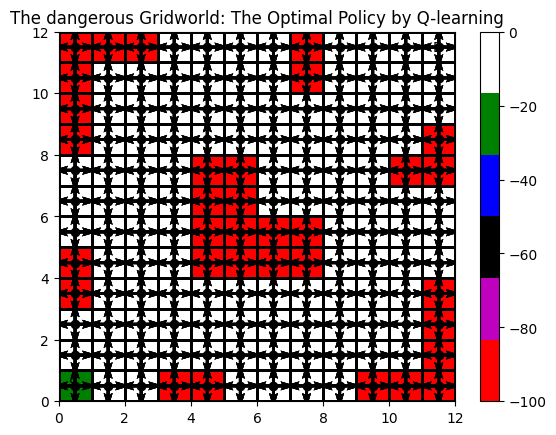

In [40]:
td_agent = TD0_linFunc_Agent(gw)
td_agent.print_policy(gw)

Completed run 0
Completed run 2000
Completed run 4000
Completed run 6000
Completed run 8000


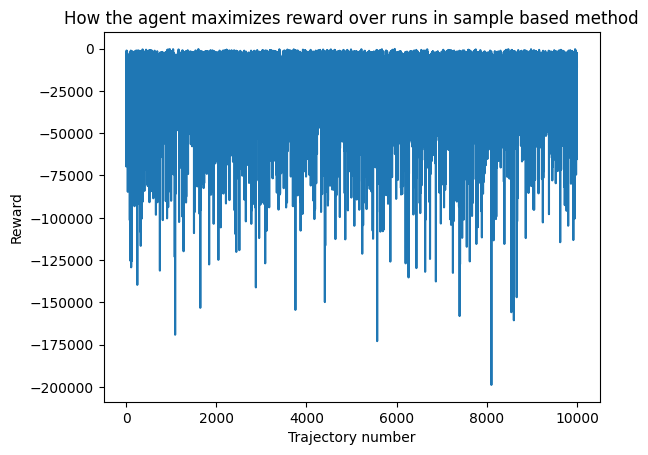

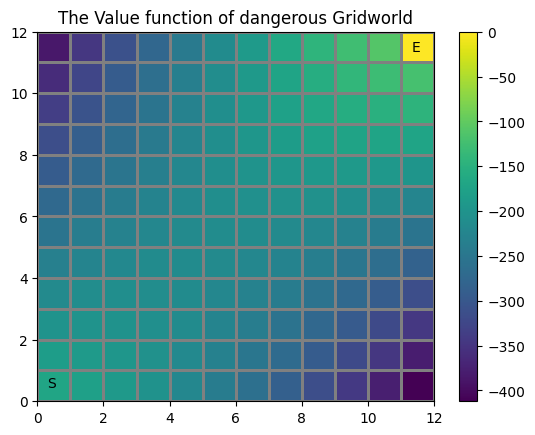

In [41]:
td_agent.TD_learning(gw, 10000, 1)
td_agent.print_value_function(gw)

**Optimal Policy**

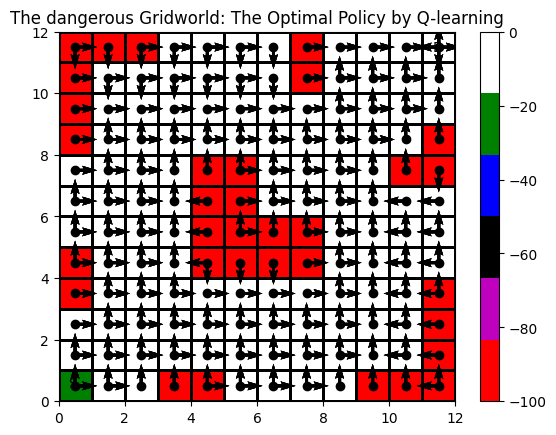

In [42]:
td_agent = TD0_linFunc_Agent(gw, agent_p_iter.pi_indicator)
td_agent.print_policy(gw)

Completed run 0
Completed run 2000
Completed run 4000
Completed run 6000
Completed run 8000


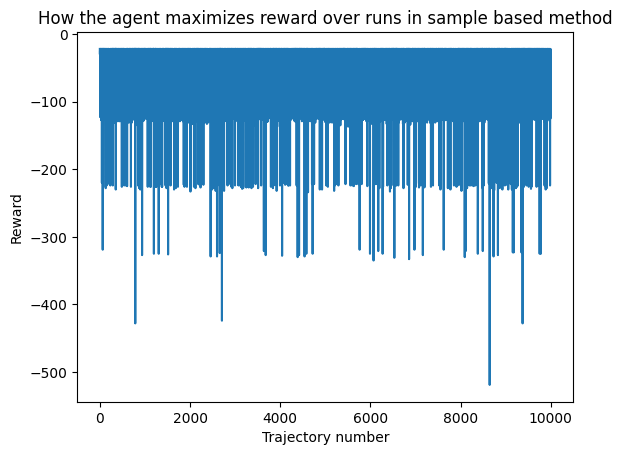

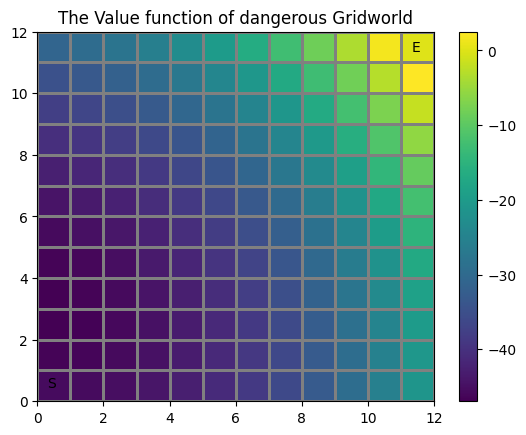

In [43]:
td_agent.TD_learning(gw, 10000, 1)
td_agent.print_value_function(gw)